# Study of a Regression problem on Franke function

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})
import warnings

warnings.filterwarnings("ignore")

from functions import *

from activation_funcs import *
from cost_funcs import *
from Schedulers import *
from FFNN import FFNN

In [2]:
seed = 42069
np.random.seed(seed)


N  = 100

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
yy, xx = np.meshgrid(x, y)

zz = FrankeFunction(xx, yy)
target = zz.reshape(-1,1)

target = (target - np.mean(target)) / np.std(target)

In [3]:

poly_degree = 4

X = create_X(xx.flatten(), yy.flatten(), poly_degree)

X_train, X_test, z_train, z_test = train_test_split(X, target, test_size=0.2)

scaler_X = StandardScaler()
scaler_z = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
z_train_scaled = scaler_z.fit_transform(z_train)
z_test_scaled = scaler_z.transform(z_test)

- epoch vs batch size
- lambda vs eta
- Schedulers
- Activation functions

In [4]:
input_shape = X.shape[1]
hidden_shape = [15]
output_shape = 1
dims =  (input_shape, *hidden_shape, output_shape)

model = FFNN(
	layer_sizes=dims,
	hidden_funcs=[sigmoid],
	output_func=identity,
	cost_func=MSE,
	cost_der=MSE_derivative,
	seed=seed
)

scheduler = AdagradMomentum(eta=0.15, momentum=0.75)
# scheduler = Adam(eta=0.001, rho=0.9, rho2=0.999)

epochs = 500
batches = 20

lmbda = 0.00001

scores = model.fit(
	X_train_scaled,
	z_train_scaled, 
	scheduler=scheduler,
	epochs=epochs,
	batches=batches,
	lmbda=lmbda,
	)

AdagradMomentum: Eta=0.15, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.00784 | R2_scores: 0.992 

In [5]:
z_pred = model.predict(X_test_scaled)
z_pred = scaler_z.inverse_transform(z_pred)

grid_size = int(np.sqrt(len(z_pred)))
xx = xx.reshape((grid_size, grid_size))
yy = yy.reshape((grid_size, grid_size))
zz = zz.reshape((grid_size, grid_size))
z_pred = z_pred.reshape((grid_size, grid_size))

fig = plt.figure(figsize = (13, 7))
axs = [fig.add_subplot(121, projection = "3d"), fig.add_subplot(122, projection = "3d")]

surf_true = axs[0].plot_surface(xx, yy, zz, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
axs[0].set_title("True Franke function")
axs[1].set_title("Predicted Franke function")
surf_predict = axs[1].plot_surface( z_pred, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
for i in range(2):
	axs[i].zaxis.set_major_locator(LinearLocator(10))
	axs[i].zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
	axs[i].set_xlabel(r"$x$")
	axs[i].set_ylabel(r"$y$")
fig.colorbar(surf_true, shrink = 0.4, aspect = 10, label = r"$f(x,y)$")
fig.colorbar(surf_predict, shrink = 0.4, aspect = 10, label = r"$f(x,y)+\varepsilon$")
plt.tight_layout()
# plt.savefig("../figs/a_Franke_surf.pdf")
plt.show()

ValueError: cannot reshape array of size 10000 into shape (44,44)

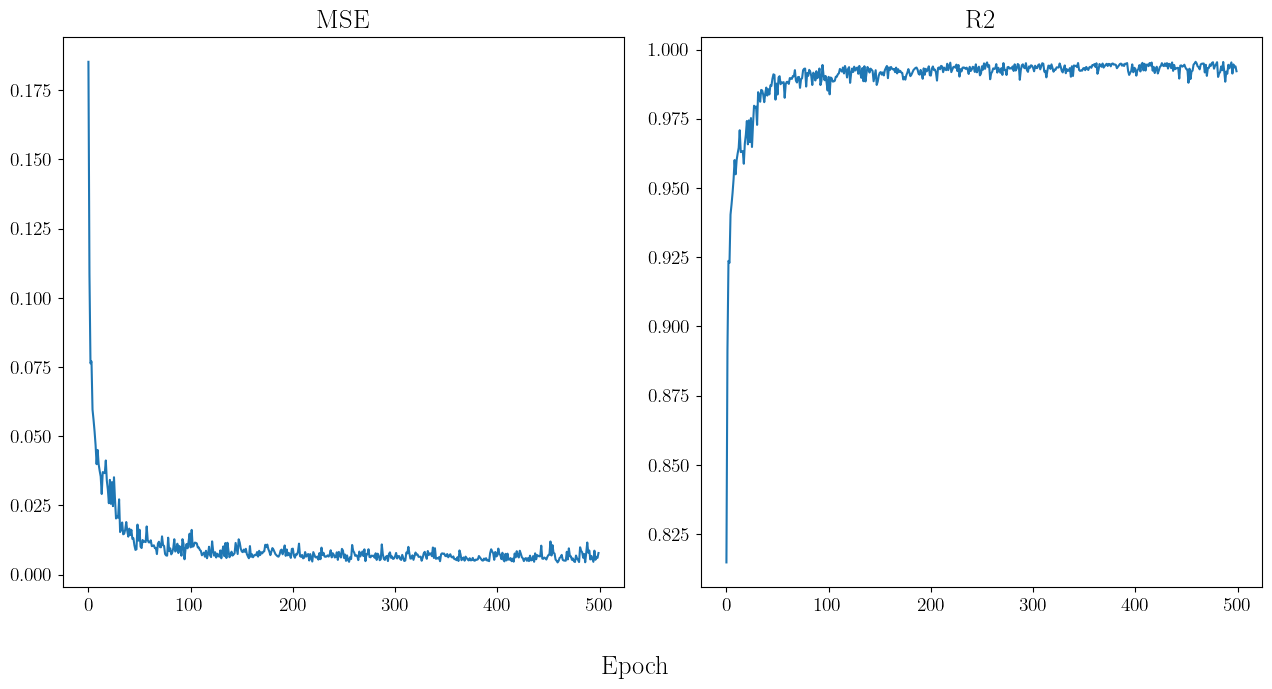

In [6]:
MSE_scores = scores["cost"]
R2_scores = scores["R2"]

fig, axs = plt.subplots(1, 2, figsize = (13, 7))
axs[0].plot(MSE_scores, label = "MSE")
axs[0].set_title("MSE")
# axs[0].set_yscale('log')  # Set y-axis to log scale

axs[1].plot(R2_scores, label = "R2")
axs[1].set_title("R2")
# axs[1].set_yscale('log')  # Set y-axis to log scale

fig.supxlabel("Epoch")

plt.tight_layout()
# plt.savefig("../figs/b_train_scores.pdf")
plt.show()

### Initializing the model

In [ ]:
input_shape = X.shape[1]
hidden_shape = [15]
output_shape = 1

dims =  (input_shape, *hidden_shape, output_shape)

model = FFNN(
			layer_sizes=dims,
			hidden_funcs=[sigmoid],
			output_func=identity,
			cost_func=MSE,
			cost_der=MSE_derivative,
			seed=seed
		)

- Discuss why we set the same hidden layers for all models

## Plotting epoch vs batch size

## Finding optimal hidden layer parameters

In [11]:

scheduler = AdagradMomentum(eta=0.15, momentum=0.75)
lmbda = 0.001

epochs_list = [100, 500, 1000, 2000]
batches_list = [1, 10, 20, 50, 100]

MSE_scores_1 = np.zeros([len(epochs_list), len(batches_list)])
R2_scores_1 = np.zeros([len(epochs_list), len(batches_list)])
MSE_test_1 = np.zeros([len(epochs_list), len(batches_list)])

for i, n_epochs in enumerate(epochs_list):
	for j, n_batches in enumerate(batches_list):
		model.reset_weights()

		scores = model.fit(
			X_train_scaled,
			z_train_scaled, 
			scheduler=scheduler,
			epochs=n_epochs,
			batches= n_batches,
			lmbda=lmbda,
			)
		print(f"Training model with {n_epochs} epochs and {n_batches} batches\n")
		# Store the final value
		MSE_scores_1[i][j] = scores["cost"][-1]
		R2_scores_1[i][j] = scores["R2"][-1]

		test_pred = model.predict(X_test_scaled)
		test_pred = scaler_z.inverse_transform(test_pred)
		MSE_test_1[i][j] = MSE(test_pred, z_test)


AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.182 | R2_scores: 0.818 Training model with 100 epochs and 1 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0453 | R2_scores: 0.955 Training model with 100 epochs and 10 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0169 | R2_scores: 0.983 Training model with 100 epochs and 20 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0180 | R2_scores: 0.982 Training model with 100 epochs and 50 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0150 | R2_scores: 0.985 Training model with 100 epochs and 100 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [======================================

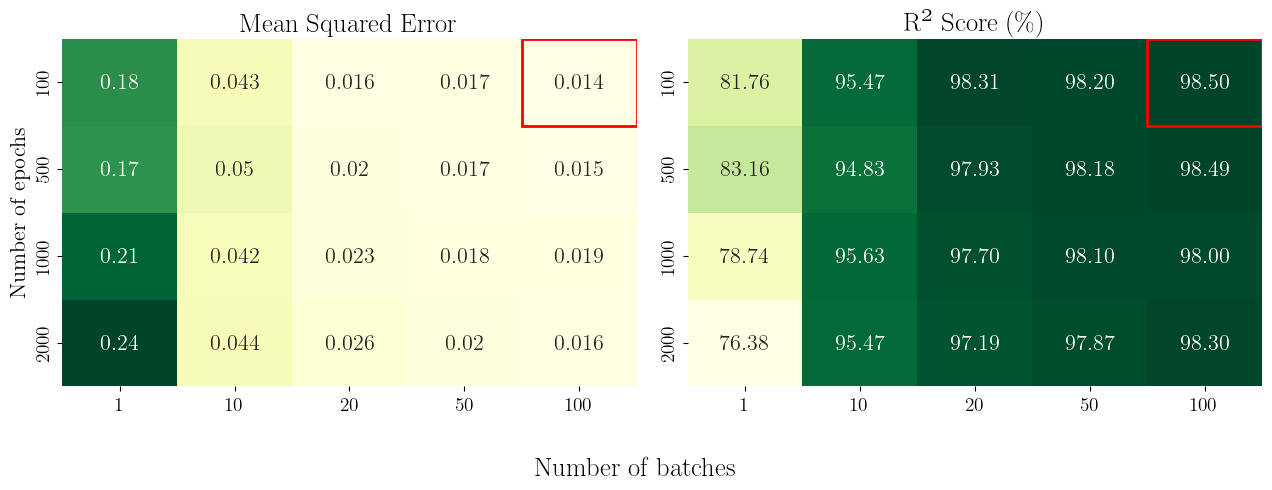

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Create masks for highlighting
mse_mask = np.zeros_like(MSE_test_1, dtype=bool)
r2_mask = np.zeros_like(R2_scores_1, dtype=bool)

# Set mask values using the optimal indices
mse_idx = np.unravel_index(np.argmin(MSE_test_1), MSE_test_1.shape)
r2_idx = np.unravel_index(np.argmax(R2_scores_1), R2_scores_1.shape)

r2_annot = np.array([[f'{val*100:.2f}%' for val in row] for row in R2_scores_1])
# Plot MSE heatmap
sns.heatmap(MSE_test_1, 
            cmap="YlGn",
            xticklabels=batches_list,
            yticklabels=epochs_list, 
            annot=True,
            ax=axs[0],
            cbar=False,
		)
axs[0].add_patch(plt.Rectangle((mse_idx[1], mse_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Plot R2 heatmap  
sns.heatmap(R2_scores_1,
            cmap="YlGn",
            xticklabels=batches_list,
            yticklabels=epochs_list,
            annot=R2_scores_1,
            fmt='.2%',
    	    	ax=axs[1],
            cbar=False,
		)

axs[1].add_patch(plt.Rectangle((r2_idx[1], r2_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Customize titles and labels
axs[0].set_title("Mean Squared Error")
axs[1].set_title("R² Score (\%)")
axs[0].set_ylabel("Number of epochs") 
fig.supxlabel("Number of batches")
plt.tight_layout()

plt.show()

## Finding optimal learning rate and regularization parameter

In [ ]:
epochs = 500
batches = 20

etas_list = [0.0001, 0.001, 0.01, 0.1, 0.5,]
lmbdas_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSE_scores_2 = np.zeros([len(etas_list), len(lmbdas_list)])
R2_scores_2 = np.zeros([len(etas_list), len(lmbdas_list)])
MSE_test_2 = np.zeros([len(etas_list), len(lmbdas_list)])

for i, n_eta in enumerate(etas_list):
	for j, n_lmbda in enumerate(lmbdas_list):
		model.reset_weights()
		scheduler = AdagradMomentum(eta=n_eta, momentum=0.8)
		scores = model.fit(
			X_train_scaled,
			z_train_scaled, 
			scheduler=scheduler,
			epochs=epochs,
			batches=batches,
			lmbda=n_lmbda,
			)
		print(f"Training model with $eta$ = {n_eta}\n")

		test_pred = model.predict(X_test_scaled)
		test_pred = scaler_z.inverse_transform(test_pred)
		MSE_test_2[i][j] = MSE(test_pred, z_test)

		# Store the final value
		MSE_scores_2[i][j] = scores["cost"][-1]
		R2_scores_2[i][j] = scores["R2"][-1]

AdagradMomentum: Eta=0.0001, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.0533 | R2_scores: 0.947  Training model with $eta$ = 0.0001

AdagradMomentum: Eta=0.0001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.0536 | R2_scores: 0.946  Training model with $eta$ = 0.0001

AdagradMomentum: Eta=0.0001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0578 | R2_scores: 0.942  Training model with $eta$ = 0.0001

AdagradMomentum: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | training_scores: 0.100 | R2_scores: 0.900   Training model with $eta$ = 0.0001

AdagradMomentum: Eta=0.0001, Lambda=0.1
  [=======================================>] 100.0% | training_scores: 0.233 | R2_scores: 0.767  Training model with $eta$ = 0.0001

AdagradMomentum: Eta=0.001, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.00311 | R

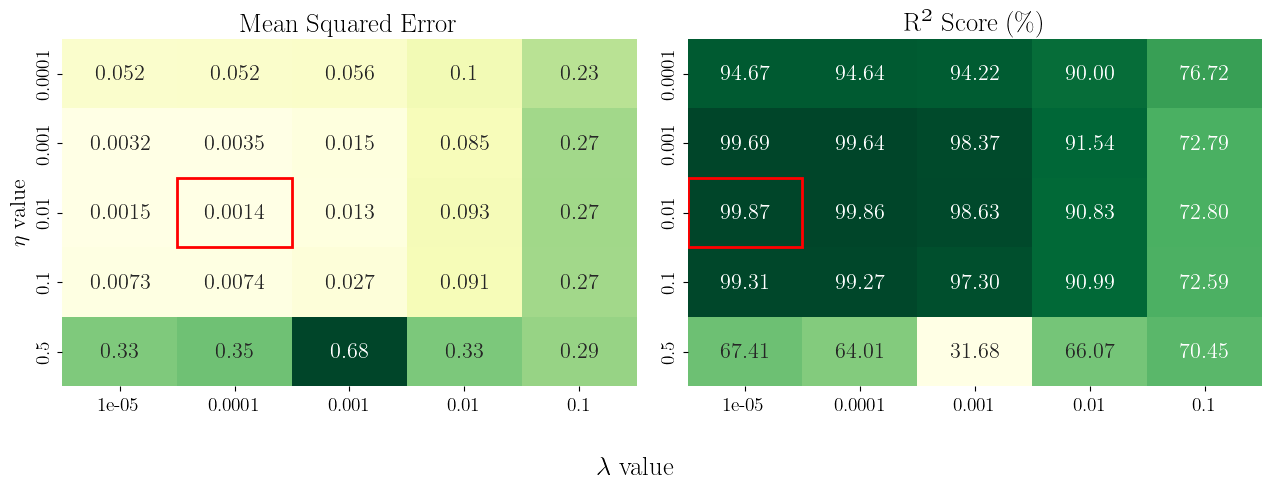

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Create masks for highlighting
mse_mask = np.zeros_like(MSE_test_2, dtype=bool)
r2_mask = np.zeros_like(R2_scores_2, dtype=bool)

# Set mask values using the optimal indices
mse_idx = np.unravel_index(np.argmin(MSE_test_2), MSE_test_2.shape)
r2_idx = np.unravel_index(np.argmax(R2_scores_2), R2_scores_2.shape)

# Plot MSE heatmap
sns.heatmap(MSE_test_2, 
            cmap="YlGn",
            xticklabels=lmbdas_list,
            yticklabels=etas_list, 
            annot=True,
            ax=axs[0],
            cbar=False,
		)
axs[0].add_patch(plt.Rectangle((mse_idx[1], mse_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Plot R2 heatmap  
sns.heatmap(R2_scores_2,
            cmap="YlGn",
            xticklabels=lmbdas_list,
            yticklabels=etas_list, 
            annot=True,
    	    	ax=axs[1],
            fmt=".2%",
            cbar=False,
		)

axs[1].add_patch(plt.Rectangle((r2_idx[1], r2_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Customize titles and labels
axs[0].set_title("Mean Squared Error")
axs[1].set_title("R² Score (\%)")
axs[0].set_ylabel(r"$\eta$ value")
fig.supxlabel(r"$\lambda$ value")
plt.tight_layout()

plt.show()

## Testing different schedulers

Constant: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.133 | R2_scores: 0.867   Training model with Constant scheduler

Momentum: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0690 | R2_scores: 0.931  Training model with Momentum scheduler

Adagrad: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0198 | R2_scores: 0.980 Training model with Adagrad scheduler

AdagradMomentum: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0163 | R2_scores: 0.984 Training model with AdagradMomentum scheduler

Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0127 | R2_scores: 0.987 Training model with Adam scheduler

RMS_prop: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.0141 | R2_scores: 0.986 Training

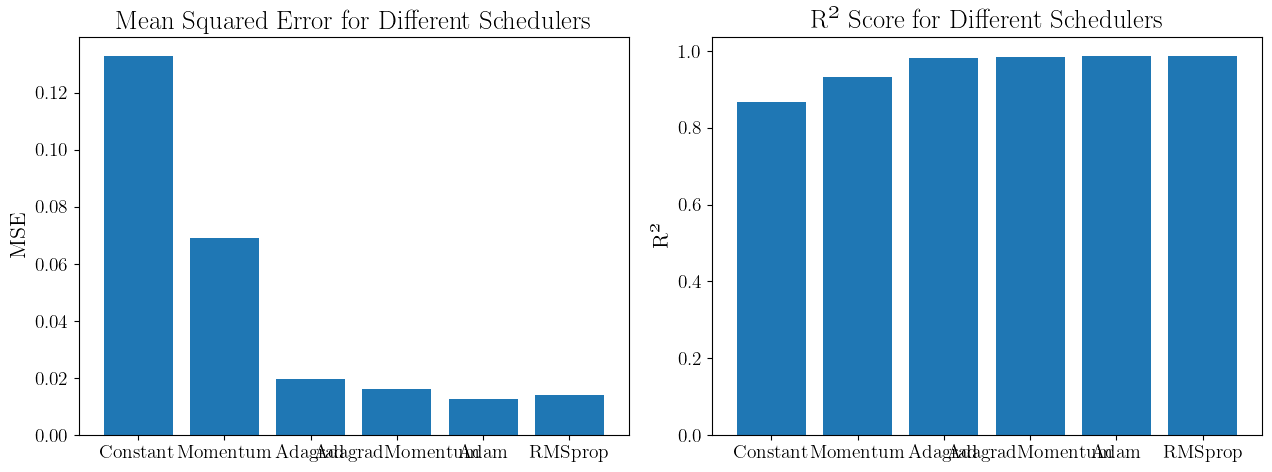

In [18]:

eta= 0.001
gamma= 0.8
rho= 0.9
rho2= 0.999

schedulers = [
	Constant(eta=eta),
	Momentum(eta=eta, momentum=gamma),
	Adagrad(eta=eta),
	AdagradMomentum(eta=eta, momentum=gamma),
	Adam(eta=eta, rho=rho, rho2=rho2),
	RMS_prop(eta=eta, rho=rho),
]

# Initialize arrays to store the results
scheduler_names = ["Constant", "Momentum", "Adagrad", "AdagradMomentum", "Adam", "RMSprop"]
MSE_scores_schedulers = np.zeros(len(schedulers))
R2_scores_schedulers = np.zeros(len(schedulers))

# Loop over each scheduler and evaluate the model
for i, scheduler in enumerate(schedulers):
	model.reset_weights()
	scores = model.fit(
		X_train_scaled,
		z_train_scaled, 
		scheduler=scheduler,
		epochs=epochs,
		batches=batches,
		lmbda=lmbda,
	)
	
	# Store the final value
	MSE_scores_schedulers[i] = scores["cost"][-1]
	R2_scores_schedulers[i] = scores["R2"][-1]

	print(f"Training model with {scheduler_names[i]} scheduler\n") 	

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

axs[0].bar(scheduler_names, MSE_scores_schedulers)
axs[0].set_title("Mean Squared Error for Different Schedulers")
axs[0].set_ylabel("MSE")

axs[1].bar(scheduler_names, R2_scores_schedulers)
axs[1].set_title("R² Score for Different Schedulers")
axs[1].set_ylabel("R²")

plt.tight_layout()
plt.show()